# NLP Preprocessing Notebook

The purpose of this notebook is to conduct the preprocessing steps that are necessary for text data in NLP. This includes tokenizing, removing stop words, vectorizing, etc.

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline
import nltk
from sklearn.feature_extraction import text 
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, roc_curve, auc, classification_report

### 1. Load the clean dataframe from `data_cleaning.ipynb`


In [49]:
# this is our corpus
clean_df = pd.read_pickle('../pickle/clean_df.pkl')

In [50]:
clean_df.head()

,total_votes,hate_speech_votes,other_votes,label,tweet,round_1_tweet
0,3,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...,as a woman you shouldnt complain about clea...
1,3,0,3,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad for cuffin dat ho...
2,3,0,3,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg you ever fuck a bitch and she sta to...
3,3,0,3,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,she look like a tranny
4,6,0,6,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,the shit you hear about me might be true or...


### creating `tweet_df` with only cleaned tweets column

In [51]:
# tweet_df = pd.DataFrame(tweet_data)

tweet_df = clean_df[['round_1_tweet', 'label']].copy()

In [52]:
tweet_df.head()

,round_1_tweet,label
0,as a woman you shouldnt complain about clea...,0
1,boy dats coldtyga dwn bad for cuffin dat ho...,0
2,dawg you ever fuck a bitch and she sta to...,0
3,she look like a tranny,0
4,the shit you hear about me might be true or...,0


In [53]:
data = tweet_df['round_1_tweet']
target = tweet_df['label']

## Remove Stop Words & Tokenize
We can use NLTK's built-in library of stop words.

In [54]:
stop_words = set(stopwords.words('english'))

In [55]:
def process_tweet(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed 

In [56]:
# applying the above function to our data/features 
processed_data = list(map(process_tweet, data))

In [57]:
total_vocab = set()
for comment in processed_data:
    total_vocab.update(comment)
len(total_vocab)

21978

## Lemmatization

In [58]:
# creating a list with all lemmatized outputs
lemmatizer = WordNetLemmatizer() 
lemmatized_output = []

for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [59]:
X_lem = lemmatized_output
# [' '.join(d) for d in processed_data]

y_lem = target
# X[3]

## Train-Test Split & Vectorize

In [60]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.20, random_state=15)

# using tf_idf vectorizor
tfidf = TfidfVectorizer(stop_words= stop_words, ngram_range=(1,2))

In [61]:
tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem = tfidf.transform(X_test_lem)

tfidf_data_train_lem

<19826x108447 sparse matrix of type '<class 'numpy.float64'>'
	with 270484 stored elements in Compressed Sparse Row format>

In [62]:
# get a quick look of the non zero elements

non_zero_cols = tfidf_data_train_lem.nnz / float(tfidf_data_train_lem.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train_lem.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 13.642893170584081
Percentage of columns containing ZERO: 0.9998741975972542


99.9% of the columns contain a zero, meaning that's a very sparse matrix

## Baseline Model

In [63]:
rf_classifier_lem = RandomForestClassifier(n_estimators=100, random_state=0)

In [64]:
rf_classifier_lem.fit(tfidf_data_train_lem, y_train_lem)

rf_test_preds_lem = rf_classifier_lem.predict(tfidf_data_test_lem)

In [65]:
rf_acc_score_lem = accuracy_score(y_test_lem, rf_test_preds_lem)
rf_f1_score_lem = f1_score(y_test_lem, rf_test_preds_lem)

In [66]:
# printing evaluation metrics up to 4th decimal place
print('Random Forest Baseline with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(rf_acc_score_lem))
print("F1 Score: {:.4}".format(rf_f1_score_lem))

Random Forest Baseline with Lemmatization Features
Testing Accuracy: 0.9439
F1 Score: 0.1824


(2.0, 0.0)

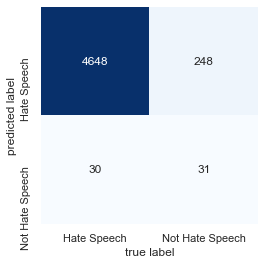

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

mat = confusion_matrix(y_test_lem, rf_test_preds_lem)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Hate Speech', 'Not Hate Speech'], yticklabels=['Hate Speech', 'Not Hate Speech'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')

# fixing matplotlib heatmap cutoff issue
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

There are a lot of false positives, which can be expected with this dataset.